<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=150 HEIGHT=100>

<CENTER>
</br>
<p><font size="5"> Speaker Diarization </span></p>
<p><font size="3">  UE Recherche  </font></p>
<p></p>
<p><font size="4"> Emmanuel Leguet - Hubert Dellon </font></p>
</p></br>
</p>
</CENTER>

# I - Presentation

This part is complementary to [Automated_transcription.ipynb](./Automated_transcription.ipynb).
The aim here is to segment an interview with two speakers. Vosk API is used to extract an *X-Vector* from an audio segment that characterizes the speaker. To do so, it required a speaker model, but also a model used for transcription. The speaker model used is [vosk-model-spk-0.4](https://alphacephei.com/vosk/models), available on Vosk website. It has been obtained via deep learning (see the associated *README.txt*). The 'transcription' model used is the same as the one used in [Automated_transcription.ipynb](./Automated_transcription.ipynb) ([vosk-model-fr-0.6-linto-2.0.0](https://alphacephei.com/vosk/models)).  
In order to distinguish both speakers, we first cut the whole audio into small units, then with Vosk we extract an *X-Vector* for each unit, and finally we use a *KMeans algorithm* to obtain two clusters from all the *X-Vectors*. As we supposed a *cluster = a speaker*, we are able associate each unit with a speaker, and thus obtain a segmentation. (Note that we first cut the audio in small units in order to get audio segments with only one speaker.)
We explore different methods to cut the audio into small segments, and then compare their results with a manual segmentation on a 5 min extract.


# II - Initialization
### I - Modules 

In [21]:
# All modules used in this script
from vosk import Model, KaldiRecognizer, SpkModel, SetLogLevel
SetLogLevel(-1) # The higher the more vosk logs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import wave
import json
import os
os.chdir('./')


### II - Models

In [22]:
# Get model & speaker model
model = Model("Model")
spk_model = SpkModel("ModelSpk/vosk-model-spk-0.4")
vectorSize = 128 # Depends on the spk_model, it's 128 for vosk-model-spk-0.4


### III - Audio
We load an audio extract that will be used to compare the different methods of segmentation with a manual segementation. 
Note that we use the same buffer size used in the sample scripts provided by Vosk, and as seen in [Automated_transcription.ipynb](./Automated_transcription.ipynb), it doesn't seem to have an influence on the *WER*. (But on the *X-Vector* extraction ?)


In [23]:
# Get the audio 
audio = wave.open("Audio/Clement1_5min_extract.wav")

# Set audio parameters
frameRate = audio.getframerate()
nFrame = audio.getnframes()
bufferSize = frameRate // 4
totalTime = nFrame / frameRate

# Times the speaker changes in the selected audio
refTimeSpkChange = [4.94, 5.22, 9.55, 12.35, 20.1, 21.02, 34.09, 35.35, 37.84, 39.5, 49.08, 51.04, 57.02, 58.52, 67.66, 121.63, 123.68, 144.68, 145.5, 150.25, 154.52, 155.49, 155.8, 171.01, 173.85, 178.85, 183.66, 184.36, 189.49, 237.02, 241.68, 295.14] 


### IV - Transcription
We transcript the audio with Vosk to get a list of time stamped words, that will be used in some of the segmentation methods. Note that, as seen in [Automated_transcription.ipynb](./Automated_transcription.ipynb), the transcription is not so accurate. The assumption is that, even if the *WER* is quite high, the word segmentation still remains useful to segment the audio in relevant small units (containing a unique speaker : neither 0, nor 2).


In [24]:
# Word transcription
audio.rewind()

rec = KaldiRecognizer(model, frameRate)
while True:
    data = audio.readframes(bufferSize)
    if len(data) == 0:
        break
    rec.AcceptWaveform(data)

finalResults = json.loads(rec.FinalResult())
wordResult = finalResults['result'] # Words with 'start' and 'end' times


# III - Functions for diarization
## I - "Cutting" functions to extract small audio units
The different methods below segment the audio in small units (actually groups of words here) and extract an *X-Vector* from each of them.


###  I - Method 0 : Group of words "chosen by Vosk" 
We 'cut' when ```rec.AcceptWaveform(data) == True```, that might be interpreted as: Vosk has processed a 'complete utterance'. With this approach we don't need the above transcription. (Note that we are actually doing a transcription in the same time than extracting the *X-Vectors*, but that transcription doesn't give the same result than the one above, because the transcription is interrupted at each group of words for extracting the vectors).


In [25]:
def cutVosk(model, spk_model, audio, frameRate, bufferSize):
    '''
    spkVectors : list of resulting X-Vectors 
    resWords : list of word groups (time stamped)
    '''
    spkVectors = []
    resWords = []

    audio.rewind()
    rec = KaldiRecognizer(model, spk_model, frameRate)

    while True:
        data = audio.readframes(bufferSize)
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data): # if complete utterance for vosk
            res = json.loads(rec.Result())
            if res['text'] != "":
                spkVectors.append(res['spk'])
                resWords.append(res['result'])

    res = json.loads(rec.FinalResult())
    if res['text'] != "":
        spkVectors.append(res['spk'])
        resWords.append(res['result'])

    return spkVectors, resWords
    

The next three methods are quite similar and use the Vosk transcription we did earlier.  
Trying to extract an *X-Vector* for each word raised an issue : when an audio segment is too short, Vosk can't extract the *X-Vector* (and since the Vosk error can't be caught, we prevent the error by looking if an audio segment is longer than minTime=0.2s, obtained experimentally). Thus, when a word is too short, we gather it with the next one (sometimes the two next words, because it's still too short). However, this approach doesn't work well as shown in the results below. Therefore, we tried to create small groups of words with different concatenation methods : the three ones prensented below. (Note that is even if we want groups of 2, we can encounter group of 3, because of the issue we mentioned).

#### II - Method 1 : Group of n words
Concatenation of *n* words for an audio segment : \[*word1_start_time*  : *wordn_end_time*\].


In [26]:
def cutGroupWords(model, spk_model, audio, frameRate, bufferSize, Words, minGroupWords, shift=0, minTime=0.2):
    '''
    minGroupWords : number of words in each group
    shift : indice of the first word for starting making groups
    minTime : see above
    Words : list containing the time stamped words (obtained with the above transcription)
    -----
    spkVectors : list of resulting X-Vectors (one for each group)
    groupWords : list with the number of words of each group
    '''
    spkVectors = []
    groupWords = []
    indW = shift
    bufferWords = []

    while True:
        # Increment the buffer of words
        if bufferWords == []:
            if indW == len(Words):
                break
            else:
                maxBuffer = min(minGroupWords, len(Words)-indW)
                for i in range(maxBuffer):
                    bufferWords.append(Words[indW])
                    indW += 1
        elif indW == len(Words):
            spkVectors.append(spkVectors[-1])
            groupWords.append(len(bufferWords))
            break
        else:
            bufferWords.append(Words[indW])
            indW += 1
        
        startTime = bufferWords[0]['start']
        stopTime = bufferWords[-1]['end']

        if stopTime - startTime >= minTime:
            # Calculate the frames 
            nFrame = int(np.ceil((stopTime - startTime) * frameRate))
            nCompleteFrames = nFrame // bufferSize
            nRestFrames = nFrame % bufferSize

            startFrame = int(np.floor(startTime * frameRate))
            audio.setpos(startFrame)
            bufferFrames = [audio.readframes(bufferSize) for i in range(nCompleteFrames)] + [audio.readframes(nRestFrames)]
            
            # Calculate a vector on the frames
            rec = KaldiRecognizer(model, spk_model, frameRate)
            for buffer in bufferFrames:
                rec.AcceptWaveform(buffer)
            res = json.loads(rec.FinalResult())
            spkVectors.append(res['spk'])

            # Reinitialize the buffer of words
            groupWords.append(len(bufferWords))
            bufferWords = []

    return spkVectors, groupWords


#### Method 2 : Group of n words
Concatenation of *n* words for an audio segment : \[*w1_start_time*:*w1_end_time*,*w2_start_time* ... ,*wn_start_time*:*wn_end_time*\].  
Note that what we do is discarding audio between words.


In [27]:
def cutGroupJustWords(model, spk_model, audio, frameRate, bufferSize, Words, minGroupWords, shift=0, minTime=0.2):
    '''
    minGroupWords : number of words in each group
    shift : indice of the first word for starting making groups
    minTime : see above
    Words : list containing the time stamped words (obtained with the above transcription)
    -----
    spkVectors : list of resulting X-Vectors (one for each group)
    groupWords : list with the number of words of each group
    '''

    spkVectors = []
    groupWords = []
    indW = shift
    bufferWords = []

    while True:
        # Increment the buffer of words
        if bufferWords == []:
            if indW == len(Words):
                break
            else:
                maxBuffer = min(minGroupWords, len(Words)-indW)
                for i in range(maxBuffer):
                    bufferWords.append(Words[indW])
                    indW += 1
        elif indW == len(Words):
            spkVectors.append(spkVectors[-1])
            groupWords.append(len(bufferWords))
            break
        else:
            bufferWords.append(Words[indW])
            indW += 1
        
        startTime = bufferWords[0]['start']
        stopTime = bufferWords[-1]['end']

        if stopTime - startTime >= minTime:
            # Calculate the frames 
            totalTime = 0
            bufferFrames = []
            for word in bufferWords:
                startTime = word['start']
                stopTime = word['end']
                totalTime += stopTime - startTime

                nFrame = int(np.ceil((stopTime - startTime) * frameRate))
                nCompleteFrames = nFrame // bufferSize
                nRestFrames = nFrame % bufferSize

                startFrame = int(np.floor(startTime * frameRate))
                audio.setpos(startFrame)
                bufferFrames += [audio.readframes(bufferSize) for i in range(nCompleteFrames)] + [audio.readframes(nRestFrames)]

            # Calculate a vector on the frames
            rec = KaldiRecognizer(model, spk_model, frameRate)
            for buffer in bufferFrames:
                rec.AcceptWaveform(buffer)
            res = json.loads(rec.FinalResult())
            spkVectors.append(res['spk'])

            # Reinitialize the buffer of words
            groupWords.append(len(bufferWords))
            bufferWords = []

    return spkVectors, groupWords
    

#### III - Method 3 : Group of n words
Concatenation of *n* words for an audio segment : \[*w1_start_time*:*w1_end_time*, blank, *w2_start_time* ... , blank, *wn_start_time*:*wn_end_time*].
Note that we are actually replacing audio between words by zeros.


In [28]:
def cutGroupBlankWords(model, spk_model, audio, frameRate, bufferSize, Words, minGroupWords, shift=0, minTime=0.2):
    '''
    minGroupWords : number of words in each group
    shift : indice of the first word for starting making groups
    minTime : see above
    Words : list containing the time stamped words (obtained with the above transcription)
    -----
    spkVectors : list of resulting X-Vectors (one for each group)
    groupWords : list with the number of words of each group
    '''

    spkVectors = []
    groupWords = []
    indW = shift
    bufferWords = []

    while True:
        # Increment the buffer of words
        if bufferWords == []:
            if indW == len(Words):
                break
            else:
                maxBuffer = min(minGroupWords, len(Words)-indW)
                for i in range(maxBuffer):
                    bufferWords.append(Words[indW])
                    indW += 1
        elif indW == len(Words):
            spkVectors.append(spkVectors[-1])
            groupWords.append(len(bufferWords))
            break
        else:
            bufferWords.append(Words[indW])
            indW += 1
        
        startTime = bufferWords[0]['start']
        stopTime = bufferWords[-1]['end']

        if stopTime - startTime >= minTime:
            # Calculate the frames 
            totalTime = 0
            bufferFrames = []
            for word in bufferWords:
                startTime = word['start']
                stopTime = word['end']
                totalTime += stopTime - startTime

                nFrame = int(np.ceil((stopTime - startTime) * frameRate))
                nCompleteFrames = nFrame // bufferSize

                startFrame = int(np.floor(startTime * frameRate))
                audio.setpos(startFrame)
                bufferFrames += [audio.readframes(bufferSize) for i in range(nCompleteFrames)]

                nRestFrames = nFrame % bufferSize
                nEmptyFrame = bufferSize - nRestFrames
                restFrames = audio.readframes(nRestFrames)
                for i in range(nEmptyFrame):
                    restFrames += bytes(2) # blank/zeros
                bufferFrames += [restFrames]
                
            # Calculate a vector on the frames
            rec = KaldiRecognizer(model, spk_model, frameRate)
            for buffer in bufferFrames:
                rec.AcceptWaveform(buffer)
            res = json.loads(rec.FinalResult())
            spkVectors.append(res['spk'])

            # Reinitialize the buffer of words
            groupWords.append(len(bufferWords))
            bufferWords = []
            

    return spkVectors, groupWords
    

## II - Function to shift groups and give the mean X-vectors of each words
This function extends methods 1 to 3. It applies one of those three methods for each possible groups of words by shifting the groups by one word at a time. Then it returns an *X-Vector* for each word, by averaging their *X-Vectors* for each group they were in. The aim is to limit the errors due to groups gathering words from both speakers.


In [29]:
def shiftGroups(minGroupWords, wordResult, cutMethod, vectorSize):
    '''
    minGroupWords : number of words in each group 
    wordResult : list containing the time stamped words
    cutMethod : cutting functions (one of the three methods)
    -----
    spkMeansVectors : list of resulting X-Vectors (one for each word)
    '''

    spkMeansVectors = np.array([np.zeros(vectorSize) for i in range(len(wordResult))])
    for shift in range(minGroupWords):
        spkVectors, groupWords = cutMethod(model, spk_model, audio, frameRate, bufferSize, wordResult, minGroupWords, shift, minTime=0.2)
        spkVectors = np.array(spkVectors)

        w = shift
        for i in range(len(groupWords)):
            for k in range(groupWords[i]):
                spkMeansVectors[w] += spkVectors[i]
                w += 1
    
    for shift in range(minGroupWords-1):
        spkMeansVectors[shift] /= shift + 1

    spkMeansVectors[minGroupWords-1:] /= minGroupWords

    return spkMeansVectors
    

## III - KMeans function
We use it with some standard parameters (influence of those parameters ?). The function also calculate a distance for each *X-Vector*, normalized between 0 and 1, such as we get 0 for the vector the furthest from one of the speakers and 1 for the vector the furthest from the other speaker.


In [30]:
# Apply kmeans algorithm to speaker X-vectors 
def kMeansProcess(spkVectors):
    '''
    spkVectors : list of X-Vectors
    -----
    spkRes : resulting labels (list of 0 and 1)
    spkDistance_normalized : list of distances for each X-Vectors to the speakers, normalized between 0 and 1
    spkCenters : resulting centers
    '''
    kmeans = KMeans(init="random", n_init=500, max_iter=1000, n_clusters=2)
    kmeans.fit(spkVectors)

    spkCenters = kmeans.cluster_centers_
    spkRes = kmeans.labels_

    spkDistance = []
    for v in spkVectors:
        spkDistance.append(np.linalg.norm(v-spkCenters[0]) - np.linalg.norm(v-spkCenters[1]))
    spkDistance_normalized = (spkDistance-min(spkDistance))/(max(spkDistance)-min(spkDistance))

    return spkRes, spkDistance_normalized, spkCenters
    

## IV - Functions to get the list of times the speaker changes from a list of *X-Vectors*
These functions use the above Kmeans function.  
(They return the median time between consecutive utterances from different speakers.)


In [31]:
# For method 0
def convertIndiceTime(spkVectors, resWords):
    '''
    spkVectors : list of X-Vectors
    resWords : list of word groups (time stamped)
    -----
    spkChangeTime : list of times the speaker changes
    '''
    spkRes, spkDistance_normalized, spkCenters = kMeansProcess(spkVectors)
    spkChangeTime = []
    for i in range(1,len(resWords)):
        if spkRes[i] != spkRes[i-1]:
            spkChangeTime.append((resWords[i][0]['start']+resWords[i-1][-1]['end'])/2)
    return spkChangeTime
    

In [32]:
# For the other methods
def indiceTime(spkMeansVectors, wordResult):
    '''
    spkMeansVectors : list of X-Vectors for each words
    wordResult : list containing the time stamped words
    -----
    spkChangeTime : list of times the speaker changes
    '''
    spkRes, spkDistance_normalized, spkCenters = kMeansProcess(spkMeansVectors)

    timeSpkChange = []
    current = spkRes[0]
    for i in range(1,len(wordResult)):
        if current !=  spkRes[i]:
            current = spkRes[i]
            timeSpkChange += [(wordResult[i-1]['end'] + wordResult[i]['start'])/2]
    
    return timeSpkChange, spkDistance_normalized


## V - Function calculating the error between automatic and manual transcription
*Relative error = Time with wrong speaker \ Total time*.  
Note that we doesn't need here to identify the speaker, so the relative error can't be superior to 0,5.


In [33]:
def errorTimeSpk(timeSpkChange, refTimeSpkChange, audio, totalTime):
    timeSpk = timeSpkChange + [totalTime]
    timeSpkRef = refTimeSpkChange + [totalTime]

    spk = 0 # 0 or 1
    i = 0 # indice for timeSpk

    spk_ref = 0 # 0 or 1
    i_ref = 0 # indice for timeSpkRef

    currentTime = [0]
    error = 0

    # We calculate the error as the sum of the times spk != spk_ref
    while timeSpk[i] != totalTime or timeSpkRef[i_ref] != totalTime:
        if timeSpk[i] < timeSpkRef[i_ref]:
            currentTime.append(timeSpk[i])
            i += 1
            spk = 1-spk
        
        else:
            currentTime.append(timeSpkRef[i_ref])
            i_ref += 1
            spk_ref = 1-spk_ref
        
        if spk == spk_ref:
            error += currentTime[i+i_ref] - currentTime[i+i_ref-1]
    
    relative_error = error / totalTime
    
    if relative_error > 0.5:
        relative_error = 1 - relative_error
    
    return relative_error
    

# III -  Results of the methods for different sizes of group words
We compare the different methods with different sizes of group words, based on the relative error.

## I - Result for Method 0


In [34]:
spkVectors_0, resWords_0 = cutVosk(model, spk_model, audio, frameRate, bufferSize) # Extraction of X-Vectors
spkChangeTime_0 = convertIndiceTime(spkVectors_0, resWords_0) # Calculate the list of times the speaker changes
error_0 = errorTimeSpk(spkChangeTime_0, refTimeSpkChange, audio, totalTime) # Calculate the relative error
print("Relative error for Method 0 : ", error_0)

Relative error for Method 0 :  0.08901662030384389


## II - Results for Method 1

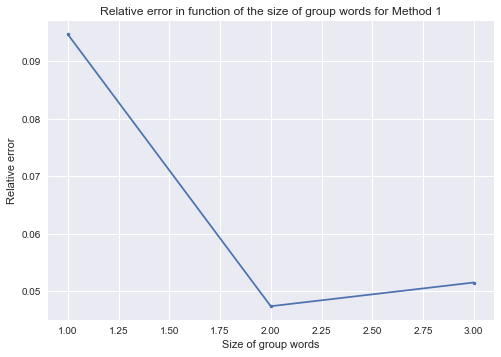

In [35]:
# We test group sizes for 1 to N1
N1 = 3

SpkMeansVectors_1 = [shiftGroups(i, wordResult, cutGroupWords, vectorSize) for i in range(1,N1+1)] # Extraction of X-Vectors
TimeSpkChange_1 = [indiceTime(smv, wordResult)[0] for smv in SpkMeansVectors_1] # Calculate lists of times the speaker changes
Distances_1 = [indiceTime(smv, wordResult)[1] for smv in SpkMeansVectors_1] # Calculate the normalized distances to speaker
Errors_1 = [errorTimeSpk(tsc, refTimeSpkChange, audio, totalTime) for tsc in TimeSpkChange_1] # Calculate the relative errors

# Plot results
plt.figure()
plt.style.use('seaborn')
plt.title('Relative error in function of the size of group words for Method 1')
plt.plot(list(range(1,N1+1)), Errors_1, ".-")
plt.xlabel("Size of group words")
plt.ylabel("Relative error")
plt.show()

## III - Results for Method 2

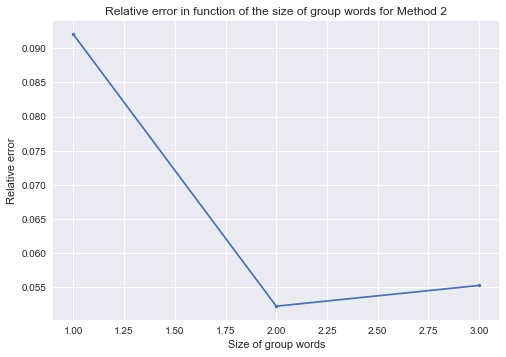

In [36]:
# We test group sizes for 1 to N2
N2 = 3

SpkMeansVectors_2 = [shiftGroups(i, wordResult, cutGroupJustWords, vectorSize) for i in range(1,N2+1)] # Extraction of X-Vectors
TimeSpkChange_2 = [indiceTime(smv, wordResult)[0] for smv in SpkMeansVectors_2] # Calculate lists of times the speaker changes
Distances_2 = [indiceTime(smv, wordResult)[1] for smv in SpkMeansVectors_2] # Calculate the normalized distances to speaker
Errors_2 = [errorTimeSpk(tsc, refTimeSpkChange, audio, totalTime) for tsc in TimeSpkChange_2] # Calculate the relative errors

# Plot results
plt.figure()
plt.title('Relative error in function of the size of group words for Method 2')
plt.plot(list(range(1,N2+1)), Errors_2, ".-")
plt.xlabel("Size of group words")
plt.ylabel("Relative error")
plt.show()

## IV - Results for Method 3

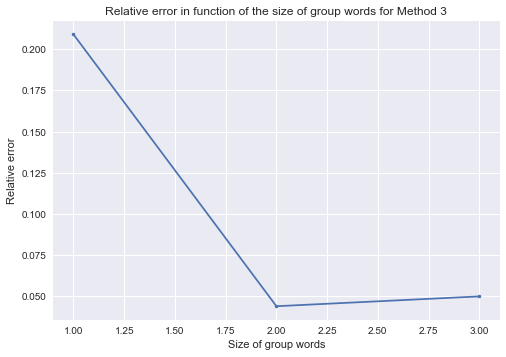

In [37]:
# We test group sizes for 1 to N3
N3 = 3

SpkMeansVectors_3 = [shiftGroups(i, wordResult, cutGroupBlankWords, vectorSize) for i in range(1,N3+1)] # Extraction of X-Vectors
TimeSpkChange_3 = [indiceTime(smv, wordResult)[0] for smv in SpkMeansVectors_3] # Calculate lists of times the speaker changes
Distances_3 = [indiceTime(smv, wordResult)[1] for smv in SpkMeansVectors_3] # Calculate the normalized distances to speaker
Errors_3 = [errorTimeSpk(tsc, refTimeSpkChange, audio, totalTime) for tsc in TimeSpkChange_3] # Calculate the relative errors

# Plot results
plt.figure()
plt.title('Relative error in function of the size of group words for Method 3')
plt.plot(list(range(1,N3+1)), Errors_3, ".-")
plt.xlabel("Size of group words")
plt.ylabel("Relative error")
plt.show()

## V - Summary plot

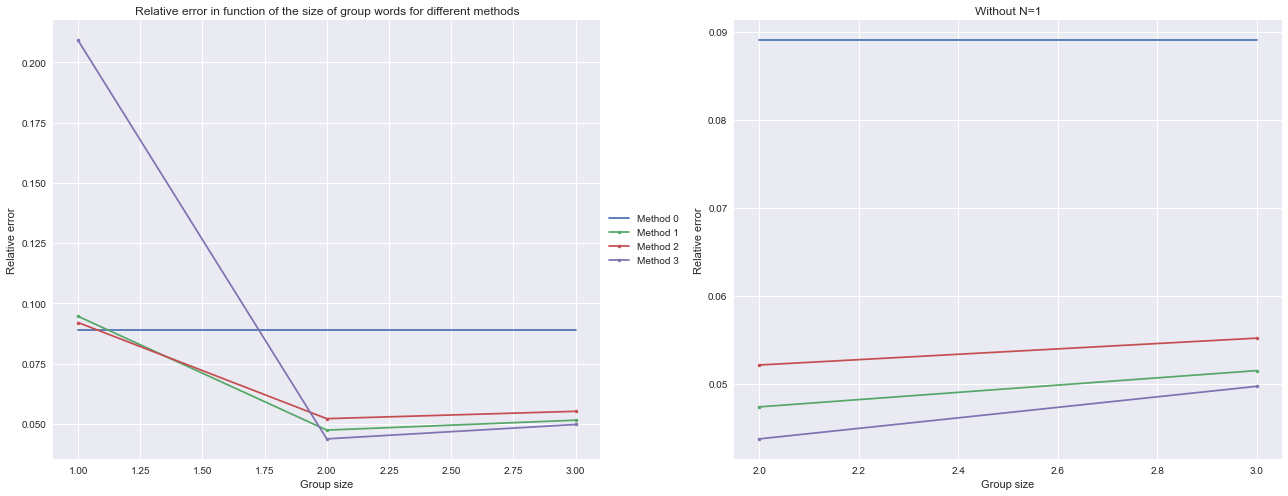

In [62]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,7))
ax1.title.set_text('Relative error in function of the size of group words for different methods')
ax1.plot(list(range(1,N1+1)), [error_0]*N1, label='Method 0') # Just for visual comparison
ax1.plot(list(range(1,N1+1)), Errors_1, '.-', label='Method 1')
ax1.plot(list(range(1,N2+1)), Errors_2, '.-', label='Method 2')
ax1.plot(list(range(1,N3+1)), Errors_3, '.-', label='Method 3')
ax1.set_xlabel("Group size")
ax1.set_ylabel("Relative error")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.title.set_text('Without N=1')
ax2.plot(list(range(2,N1+1)), [error_0]*(N1-1), label='Method 0') # Just for visual comparison
ax2.plot(list(range(2,N1+1)), Errors_1[1:], '.-', label='Method 1')
ax2.plot(list(range(2,N2+1)), Errors_2[1:], '.-', label='Method 2')
ax2.plot(list(range(2,N3+1)), Errors_3[1:], '.-', label='Method 3')
ax2.set_xlabel("Group size")
ax2.set_ylabel("Relative error")
plt.tight_layout()
plt.show()

## VI - Detailed results for what seems to be the most effective method
The last method (3) minimizes the relative error with groups of 2 words, so we look more closely into it's result.

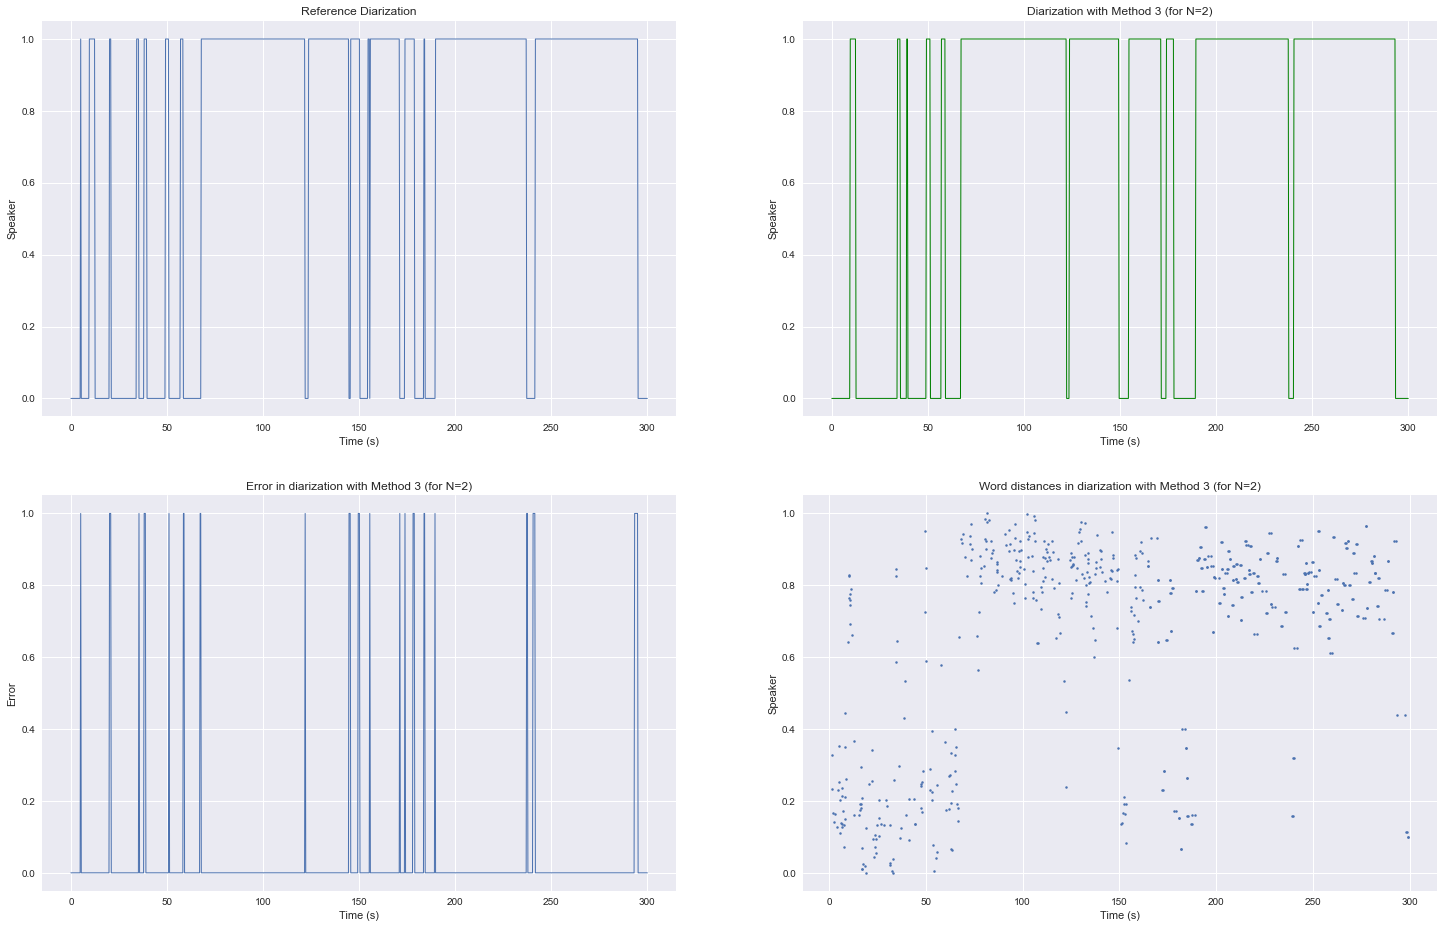

In [41]:
nTime = 1000 # Time step
listTime = np.linspace(0, totalTime, nTime)

spkList = [0]
spkListRef = [0]
timeSpkChange = TimeSpkChange_3[1] # Method 3, N=2

i = 0
j = 0
for k in range(1,nTime):
    if i < len(timeSpkChange) and listTime[k] > timeSpkChange[i]:
        spkList.append(1-spkList[-1])
        i += 1
    else:
         spkList.append(spkList[-1])
    if j < len(refTimeSpkChange) and listTime[k] > refTimeSpkChange[j]:
        spkListRef.append(1-spkListRef[-1])
        j += 1
    else:
        spkListRef.append(spkListRef[-1])


fig, axs = plt.subplots(2, 2, figsize=(25,16))

axs[0,0].set_title('Reference Diarization')
axs[0,0].plot(listTime, spkListRef, linewidth=1)
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Speaker')

axs[0,1].set_title('Diarization with Method 3 (for N=2)')
axs[0,1].plot(listTime, spkList, 'green', linewidth=1)
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_ylabel('Speaker')

axs[1,0].set_title('Error in diarization with Method 3 (for N=2)')
axs[1,0].plot(listTime, [abs(spkListRef[i]-spkList[i]) for i in range(len(listTime))], linewidth=1)
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Error')

axs[1,1].set_title('Word distances in diarization with Method 3 (for N=2)')
axs[1,1].plot([(w['start'] + w['end'])/2 for w in wordResult], [d for d in Distances_3[1]], '.', markersize=5)
axs[1,1].set_xlabel('Time (s)')
axs[1,1].set_ylabel('Speaker')

fig.show()


#### Manual Segmentation
* The manual segmentation was obtained by listening and writing down when the speaker changes (with Audacity to visualize in the same time the audio signal).
* The manual segmentation is not so precise. First, because between different speakers utterances, it's approximately the median time that have been selected. Second, because sometimes both speakers are talking in the same time (see red parts in the *.docx* file in *Audio/*).
* The audio extract for the comparison was selected at the beginning of the interview, because this is the part in which the frequency of speaker change is the highest. In general, in the rest of the interview, the utterances are longer. So, we intend to illustrate something that comes close to a 'worst case'.

#### Results
* The main parts seem well segmented, and the errors remain local. (This is actually a good point in the approach here: we are not just looking at when the speaker changes.)
* Moreover, most of the errors seem to be located where there are fast speaker changes.
* Because of the scale and because the manual segmentation is not so precise, the *Error in diarization* graph is not so relevant here.
* The last graph does not seem to show a correlation between errors and normalized distances closed to 0,5.


# IV - Conclusion

The previous part shows encouraging results, and seems to demonstrate that speaker diarization for these kind of interviews is achievable. However, the error metric used here is not informative enough and should be improved to be more accurate (removing parts with no utterances for example).  
Besides, far more than a 5 minutes extract is required to get a clear idea of what works or not. Also, the different methods could be better compared, not only with the error measure.  
It could be really interesting to try to sort out the issue for word by word vector extraction.  
It depends on your setup, but an diarization required for us about 1-1,5 the time of the input audio.  
To conclude, the approach developed here could be a useful baseline to implement a complete algorithm to separate speakers in such interviews.
